In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys; sys.path.append('../')
import torch
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from hottopic.base import buildmethod, checkmethod, HotTopic
from hottopic.utils.acts import Dirichlet
from hottopic.utils.nets import OPTIM, Encoder, MLP
from hottopic.utils.sims import make_dataset
from hottopic.utils.figs import show_dataset

In [16]:
class RSB(HotTopic, nn.Module):
    def __init__(self, max_topics=100, *, channels=(128, 32), kld_scale=.1, optim='adam', desc='RSB', random_state=None):
        super().__init__(desc, random_state)

        self.max_topics = max_topics
        self.channels = channels
        self.kld_scale = kld_scale
        self.optim = optim

        self._n_steps = 100
    
    def _build(self, X, min_topics=5, learning_rate=1e-2, batch_size=128, shuffle=True):
        in_channels, self.n_topics_, self._batch_size = X.shape[-1], min_topics, batch_size
        self._topics = torch.rand((self.max_topics, self.channels[-1]))
        self._loader, self._dirichlet = DataLoader(X, self._batch_size, shuffle), Dirichlet()
        self._encoder = Encoder(in_channels, *self.channels)
        self._b_model = nn.RNN(self.channels[-1], self.channels[-1], self.max_topics)
        self._t_model = nn.RNN(self.channels[-1], self.channels[-1], self.max_topics)
        self._decoder = MLP(self.channels[-1], in_channels, final_bias=False, final_act='softmax', dim=-1)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate)
        self.train()

        return self
    
    def _step(self):
        loss = 0.

        for x in self._loader:
            z, kl = self._encoder(x, return_kld=True)
            
            b = self._dirichlet(z@self._b_model(z)[1][:self.n_topics_ - 1].T)
            x_ = b@self._decoder(self._t_model(self._topics[:self.n_topics_])[1][:self.n_topics_])
            
            x_loss = (x_ - x).square().sum().sqrt() + self.kld_scale*kl
            x_loss.backward()
            loss += x_loss.item()/self._batch_size

        self._optim.step()
        self._optim.zero_grad()

        return loss
    
    def _predict(self, X, eval=True):
        if eval:
            self.eval()

        topics = (X@self._decoder[0][0].weight[:self.n_topics_].detach()).argmax(-1)

        return topics
    
    def forward(self, X, eval=True):
        topics = self._predict(X, eval)

        return topics

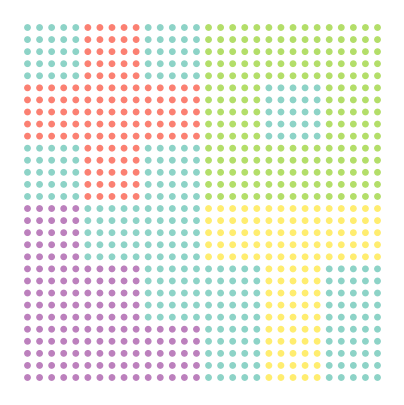

In [17]:
data, labels = make_dataset(block_size=5, return_tensor=True)
show_dataset(data, labels)

In [18]:
n_topics = 5
model = RSB()._build(data[:, 3:])
z = model._encoder(data[:, 3:])

In [19]:
class RNN(nn.Module):
    pass

In [ ]:
def frnn(z):
    pass

def fsb(n):
    pass

z = model._encoder(data[:, 3:])
n = frnn(z)


In [81]:
rnn_sb.num_layers

100

In [80]:
rnn_sb = nn.RNN(z.shape[-1], z.shape[-1], model.max_topics)

def f_rnn(x, n_topics, max_topics=100):
    rnn = nn.RNN(x.shape[-1], x.shape[-1], max_topics)
    hx = torch.zeros((rnn.num_layers, rnn.hidden_size))
    h_k_minus_1, h_k = hx.clone(), hx.clone()
    H = torch.zeros((n_topics, x.shape[-1]))

    for k in range(n_topics):
        

f_rnn(z, 5)

torch.Size([100, 32])


In [77]:
x, y, _ = z.shape

ValueError: not enough values to unpack (expected 3, got 2)

In [74]:
z.shape

torch.Size([900, 32])

In [68]:
rnn_sb = nn.RNN(z.shape[-1], model.max_topics, model.max_topics)
o, h = rnn_sb(z)
# eta = z@h[:n_topics - 1].T
# theta = model._dirichlet(eta)

# theta.shape

In [69]:
o.shape

torch.Size([900, 100])

In [63]:
rnn_topic = nn.RNN(z.shape[-1], z.shape[-1], model.max_topics)
t = torch.rand((model.max_topics, z.shape[-1]))
_, h = rnn_topic(t)


torch.Size([100, 32])

In [ ]:
            b = self._dirichlet(z@self._b_model(z)[1][:self.n_topics_ - 1].T)
            x_ = b@self._decoder(self._t_model(self._topics[:self.n_topics_])[1][:self.n_topics_])
            

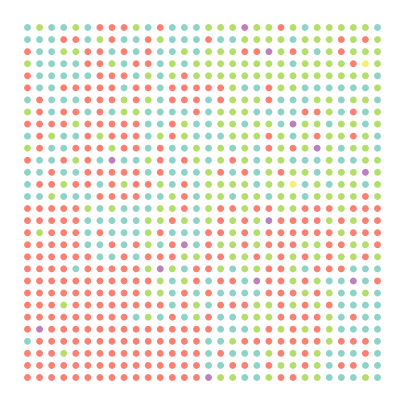

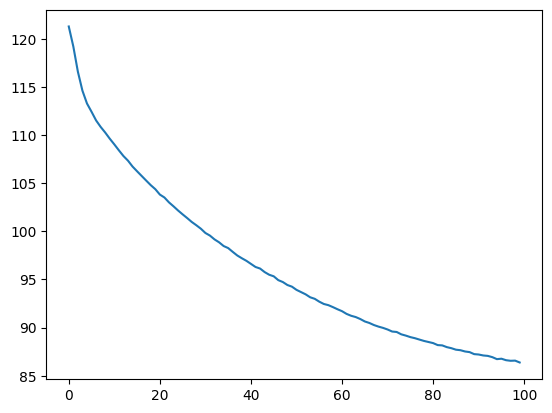

In [143]:
# model = RSB()
# model.fit(data[:, 3:], n_steps=100, min_topics=5)
# show_dataset(data, topics)
# plt.show()

topics = torch.zeros((model.n_topics_, model.channels[-1]))
z = model._encoder(data[:, 3:])
topics = relabel(model._dirichlet(z@model._b_model(z)[1][:model.n_topics_ - 1].T).argmax(-1))
show_dataset(data, topics)
plt.show()

plt.plot(range(len(model.log_)), model.log_)
plt.show()